In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
isomer_df = pd.read_csv('data/anticancer_IC50_isomeric_pred.csv')
canonical_df = pd.read_csv('data/anticancer_IC50_canonical_pred.csv')

print(isomer_df.head())
print(canonical_df.head())

                                     isomeric_SMILES  \
0  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
1  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
2  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
3  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
4  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   

                                              TARGET  Standard Value  \
0  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...             6.0   
1  MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...             2.0   
2  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...            11.0   
3  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...            15.0   
4  MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...            14.0   

   isomeric_SMILES_AFFINITY     pIC50  
0                  9.412930  8.221849  
1                  8.460589  8.698970  
2                  9.412930  7.958607  
3                  9.412930  7.823909  
4                  8.460589  7

In [3]:
key_cols = ['pIC50', 'TARGET']

# 1) 공통 열 'Standard Value' 제거
iso = isomer_df.drop(columns=['Standard Value'], errors='ignore').copy()
can = canonical_df.drop(columns=['Standard Value'], errors='ignore').copy()

# 2) 중복 키 대응: 같은 키 내 발생 순서 인덱스 부여
iso['__kidx__'] = iso.groupby(key_cols).cumcount()
can['__kidx__'] = can.groupby(key_cols).cumcount()

# 3) 가로 병합(리네임 안 함, 충돌 시 접미사만 부여)
df = iso.merge(
    can, on=key_cols + ['__kidx__'], how='outer', suffixes=('_iso', '_can')
).drop(columns='__kidx__')

print(df.head())

                                     isomeric_SMILES  \
0  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
1  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
2  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
3  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   
4  CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...   

                                              TARGET  \
0  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...   
1  MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...   
2  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...   
3  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...   
4  MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...   

   isomeric_SMILES_AFFINITY     pIC50  \
0                  9.412930  8.221849   
1                  8.460589  8.698970   
2                  9.412930  7.958607   
3                  9.412930  7.823909   
4                  8.460589  7.853872   

                                    canonical_SMILES  \
0  CN(C)C/C=C/C(=O)Nc1c

In [4]:
def parity_plot(df, xcol, ycol, pred_col, title, color='C0', s=50, alpha=0.6):
    tmp = df[['pIC50', pred_col]].dropna().copy()
    x = tmp['pIC50'].to_numpy()
    y = tmp[pred_col].to_numpy()
    
    # PCC
    pcc = np.corrcoef(x, y)[0, 1]
    
    # 축 범위(데이터 기반, 살짝 패딩)
    lo = min(x.min(), y.min())
    hi = max(x.max(), y.max())
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    lo, hi = lo - pad, hi + pad

    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=tmp, x='pIC50', y=pred_col, alpha=alpha, color=color, s=s)
    
    # y=x 대각선 + PCC를 legend에 표시 (label에 PCC 포함)
    plt.plot([lo, hi], [lo, hi], 'k--', alpha=0.4, label=f'PCC = {pcc:.3f}')
    
    plt.xlabel(xcol, fontsize=16)
    plt.ylabel(ycol, fontsize=16)
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.grid(True, alpha=0.2)
    plt.title(title, fontsize=16)
    plt.legend(loc='upper left', fontsize=14)  # 여기서 legend 사용
    plt.tight_layout()
    plt.show()

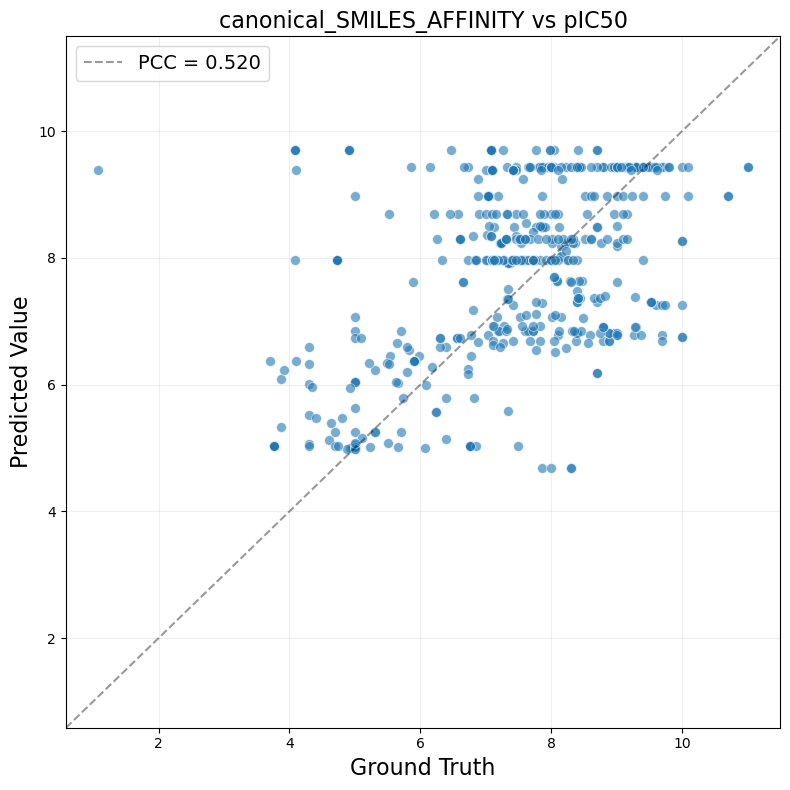

In [5]:
# 1) canonical vs pIC50
parity_plot(df, xcol='Ground Truth', ycol='Predicted Value',
            pred_col='canonical_SMILES_AFFINITY',
            title='canonical_SMILES_AFFINITY vs pIC50')

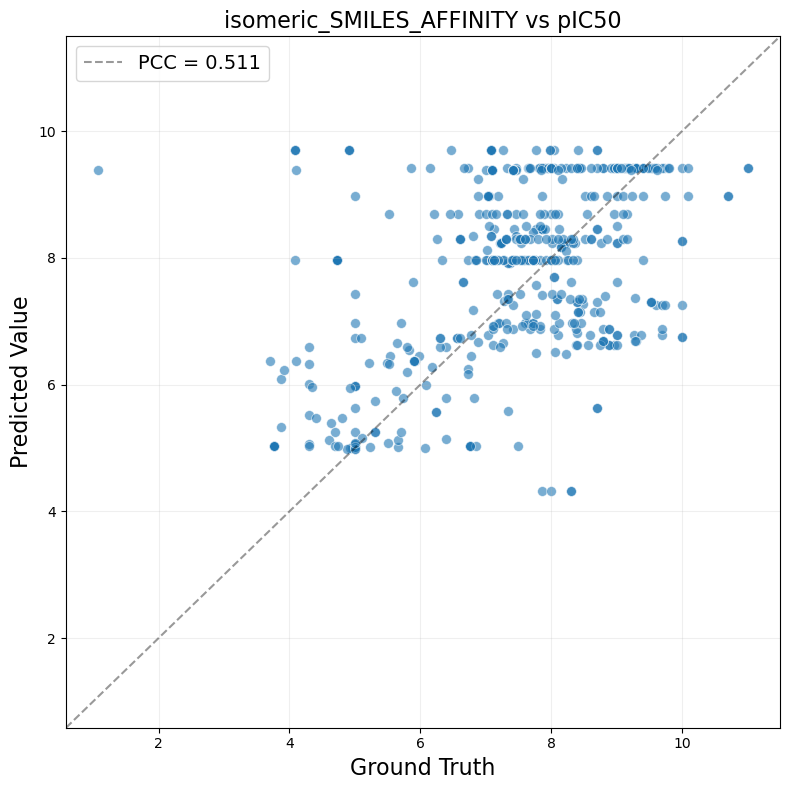

In [6]:
# 2) isomeric vs pIC50
parity_plot(df, xcol='Ground Truth', ycol='Predicted Value',
            pred_col='isomeric_SMILES_AFFINITY',
            title='isomeric_SMILES_AFFINITY vs pIC50')

In [7]:
tmp = df[['canonical_SMILES_AFFINITY', 'isomeric_SMILES_AFFINITY']].dropna().copy()
tmp['diff'] = tmp['canonical_SMILES_AFFINITY'] - tmp['isomeric_SMILES_AFFINITY']
tmp['abs_diff'] = tmp['diff'].abs()

mean_diff = tmp['diff'].mean()
std_diff = tmp['diff'].std(ddof=1)
mae = tmp['abs_diff'].mean()

print(f"Signed diff: mean={mean_diff:.4f}, std={std_diff:.4f}, MAE={mae:.4f}")

Signed diff: mean=0.0110, std=0.1010, MAE=0.0367


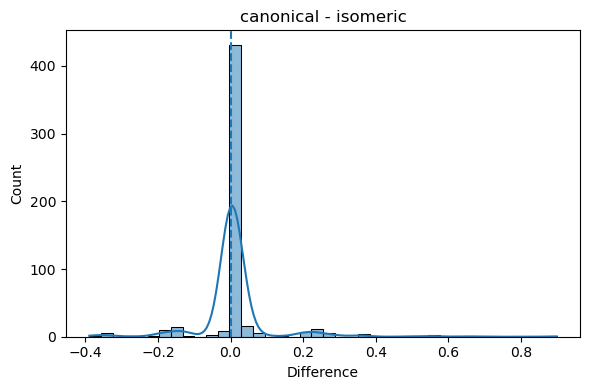

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(tmp['diff'], bins=40, kde=True)
plt.axvline(0, linestyle='--')
plt.title('canonical - isomeric')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

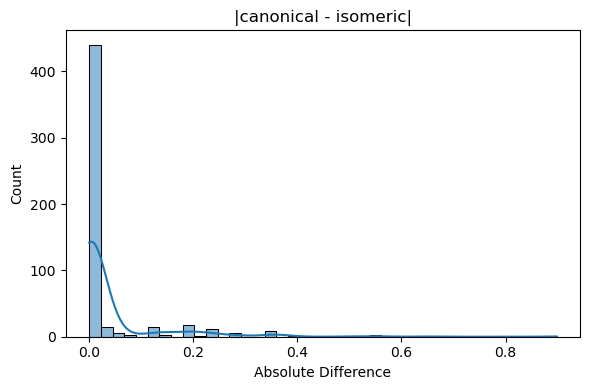

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(tmp['abs_diff'], bins=40, kde=True)
plt.title('|canonical - isomeric|')
plt.xlabel('Absolute Difference')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [14]:
tmp.head()

,canonical_SMILES_AFFINITY,isomeric_SMILES_AFFINITY,diff,abs_diff
0,9.431912,9.412930,0.018982,0.018982
1,8.492894,8.460589,0.032305,0.032305
2,9.431912,9.412930,0.018982,0.018982
3,9.431913,9.412930,0.018983,0.018983
4,8.492894,8.460589,0.032305,0.032305


In [15]:
tmp.to_csv('results/canonical_isomer_diff.csv', index=False)

In [18]:
num_zero = (tmp['diff'] == 0).sum()

print(len(tmp))
print(num_zero)

530
292
